<a href="https://colab.research.google.com/github/sergioGarcia91/ML_Carolina_Bays/blob/main/15c_U_Net_Train_12chanels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

In [ ]:
!pip install tables

In [ ]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import h5py
import multiprocessing
import joblib

from sklearn.model_selection import train_test_split

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

# Verificar si CUDA (GPU) está disponible
if torch.cuda.is_available():
    print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    print("GPU no disponible, usando CPU.")

GPU disponible: NVIDIA A100-SXM4-40GB


In [ ]:
device

device(type='cuda')

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Change Font of the Figures

In [ ]:
!wget https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf

--2025-05-21 18:41:56--  https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf [following]
--2025-05-21 18:41:57--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘Times New Roman.ttf’

Times New Roman.ttf 100%[===================>] 814.89K  --.-KB/s    in 0.05s   

2025-05-21 18:41:57 (14.5 MB/s) - ‘Times New Roman.ttf’ saved [834452/834452]



In [ ]:
import matplotlib.font_manager as fm

In [ ]:
# Path to the custom font
font_path = 'Times New Roman.ttf'

# Add the font to the Matplotlib font manager
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)

# Get the font name to use in rcParams
font_name = font_prop.get_name()
font_name

'Times New Roman'

In [ ]:
plt.rcParams['font.family'] = font_name

# Funtions

In [ ]:
def normalized_index(B1, B2):
  x = (B2 - B1) / (B2 + B1)
  x = np.nan_to_num(x, nan=0.0, posinf= 1.0)
  x = (x + 1 ) / 2
  x = np.expand_dims(x, axis=1)
  return x


https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [ ]:
# import the necessary packages
#from . import config
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

In [ ]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, kernel_size=3, padding=1)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, kernel_size=3, padding=1)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

In [ ]:
class Encoder(Module):
	def __init__(self, channels=(12, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

In [ ]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

In [ ]:
class UNet(Module):
  def __init__(self, encChannels=(12, 16, 32, 64),
              decChannels=(64, 32, 16),
              nbClasses=1, retainDim=True,
              #outSize=(config.INPUT_IMAGE_HEIGHT,  config.INPUT_IMAGE_WIDTH)):
              outSize=(64,  64)):
    super().__init__()
    # initialize the encoder and decoder
    self.encoder = Encoder(encChannels)
    self.decoder = Decoder(decChannels)
    # initialize the regression head and store the class variables
    self.head = Conv2d(decChannels[-1], nbClasses, 1)
    self.retainDim = retainDim
    self.outSize = outSize

  def forward(self, x):
    # grab the features from the encoder
    encFeatures = self.encoder(x)
    # pass the encoder features through decoder making sure that
    # their dimensions are suited for concatenation
    decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])
    # pass the decoder features through the regression head to
    # obtain the segmentation mask
    map = self.head(decFeatures)
    # check to see if we are retaining the original output
    # dimensions and if so, then resize the output to match them
    if self.retainDim:
      map = F.interpolate(map, self.outSize)
    # return the segmentation map

    return map

# Load Data

In [ ]:
path_save_h5 = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/Dataset_h5'

h5_file = os.listdir(path_save_h5)
h5_file

['dataset_AOI_01_32x32.h5',
 'dataset_AOI_02_32x32.h5',
 'dataset_AOI_03_32x32.h5',
 'dataset_AOI_04_32x32.h5',
 'dataset_AOI_02_64x64.h5',
 'dataset_AOI_01_64x64.h5',
 'dataset_AOI_03_64x64.h5',
 'dataset_AOI_04_64x64.h5']

In [ ]:
# Abrir archivo en modo lectura
with h5py.File(os.path.join(path_save_h5,'dataset_AOI_01_64x64.h5'), 'r') as f:
    # Ver todas las claves del archivo (datasets o grupos)
    print("Keys:", list(f.keys()))

    # Acceder a un dataset específico
    data_X_1 = f['AOI_01_X'][::2]
    data_y_1 = f['AOI_01_y'][::2]
    print(data_X_1.shape, data_y_1.shape)

# Abrir archivo en modo lectura
with h5py.File(os.path.join(path_save_h5,'dataset_AOI_03_64x64.h5'), 'r') as f:
    # Ver todas las claves del archivo (datasets o grupos)
    print("Keys:", list(f.keys()))

    # Acceder a un dataset específico
    data_X_2 = f['AOI_03_X'][::2]
    data_y_2 = f['AOI_03_y'][::2]
    print(data_X_2.shape, data_y_2.shape)

data_X = np.concatenate((data_X_1, data_X_2), axis=0)
data_y = np.concatenate((data_y_1, data_y_2), axis=0)
print(data_X.shape, data_y.shape)

Keys: ['AOI_01_FC_percentaje', 'AOI_01_X', 'AOI_01_y']
(47250, 7, 64, 64) (47250, 64, 64)
Keys: ['AOI_03_FC_percentaje', 'AOI_03_X', 'AOI_03_y']
(47250, 7, 64, 64) (47250, 64, 64)
(94500, 7, 64, 64) (94500, 64, 64)


In [ ]:
data_X.shape, data_y.shape

((94500, 7, 64, 64), (94500, 64, 64))

## New channels

In [ ]:
# B3 --> axis 2
# B6 --> axis 5
# B4_B1 --> axis 7
data_X = np.concatenate((data_X, normalized_index(data_X[:, 0, :, :], data_X[:, 3, :, :])), axis=1)

# B4_B3 --> axis 8
data_X = np.concatenate((data_X, normalized_index(data_X[:, 2, :, :], data_X[:, 3, :, :])), axis=1)

# B7_B3 --> axis 9
data_X = np.concatenate((data_X, normalized_index(data_X[:, 2, :, :], data_X[:, 6, :, :])), axis=1)

# B6_B4 --> axis 10
data_X = np.concatenate((data_X, normalized_index(data_X[:, 3, :, :], data_X[:, 5, :, :])), axis=1)

# B6_B5 --> axis 11
data_X = np.concatenate((data_X, normalized_index(data_X[:, 4, :, :], data_X[:, 5, :, :])), axis=1)

data_X.shape

<ipython-input-11-9a76386516fa>:2: RuntimeWarning: invalid value encountered in divide
  x = (B2 - B1) / (B2 + B1)


(94500, 12, 64, 64)

## Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_X,
                                                    data_y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train).unsqueeze(1).float()  # añade canal, y asegúrate de tipo float

print(X_train.shape, y_train.shape)

torch.Size([75600, 12, 64, 64]) torch.Size([75600, 1, 64, 64])


In [ ]:
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test).unsqueeze(1).float()  # añade canal, y asegúrate de tipo float#, dtype=torch.long).squeeze()

print(X_test.shape, y_test.shape)

torch.Size([18900, 12, 64, 64]) torch.Size([18900, 1, 64, 64])


In [ ]:
# Agrupar en un dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [ ]:
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,# 32 con CPU GPU 01... 256 con GPU 02
                          shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,# 32 con CPU GPU 01 ... 256 con GPU 02
                         shuffle=False, num_workers=2)

## Train

In [ ]:
# import the necessary packages
#from pyimagesearch.dataset import SegmentationDataset
#from pyimagesearch.model import UNet
#from pyimagesearch import config
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

In [ ]:
lr_unet = 0.0001

# initialize our UNet model
unet = UNet().to(device)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=lr_unet)
# calculate steps per epoch for training and test set
trainSteps = len(train_dataset) // BATCH_SIZE
testSteps = len(test_dataset) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [ ]:
NUM_EPOCHS = 400

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(train_loader):
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in test_loader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


  0%|          | 1/400 [00:15<1:44:35, 15.73s/it]

[INFO] EPOCH: 1/400
Train loss: 0.392231, Test loss: 0.3511


  0%|          | 2/400 [00:29<1:37:08, 14.64s/it]

[INFO] EPOCH: 2/400
Train loss: 0.315545, Test loss: 0.2956


  1%|          | 3/400 [00:43<1:34:55, 14.35s/it]

[INFO] EPOCH: 3/400
Train loss: 0.290834, Test loss: 0.3034


  1%|          | 4/400 [00:57<1:33:28, 14.16s/it]

[INFO] EPOCH: 4/400
Train loss: 0.284012, Test loss: 0.2809


  1%|▏         | 5/400 [01:11<1:32:39, 14.07s/it]

[INFO] EPOCH: 5/400
Train loss: 0.279355, Test loss: 0.2779


  2%|▏         | 6/400 [01:25<1:31:56, 14.00s/it]

[INFO] EPOCH: 6/400
Train loss: 0.277114, Test loss: 0.2788


  2%|▏         | 7/400 [01:39<1:32:31, 14.13s/it]

[INFO] EPOCH: 7/400
Train loss: 0.274625, Test loss: 0.2735


  2%|▏         | 8/400 [01:54<1:32:51, 14.21s/it]

[INFO] EPOCH: 8/400
Train loss: 0.274265, Test loss: 0.2725


  2%|▏         | 9/400 [02:08<1:32:46, 14.24s/it]

[INFO] EPOCH: 9/400
Train loss: 0.271337, Test loss: 0.2700


  2%|▎         | 10/400 [02:22<1:32:42, 14.26s/it]

[INFO] EPOCH: 10/400
Train loss: 0.269390, Test loss: 0.2677


  3%|▎         | 11/400 [02:36<1:32:25, 14.26s/it]

[INFO] EPOCH: 11/400
Train loss: 0.266826, Test loss: 0.2747


  3%|▎         | 12/400 [02:51<1:32:11, 14.26s/it]

[INFO] EPOCH: 12/400
Train loss: 0.264344, Test loss: 0.2682


  3%|▎         | 13/400 [03:05<1:32:15, 14.30s/it]

[INFO] EPOCH: 13/400
Train loss: 0.261399, Test loss: 0.2616


  4%|▎         | 14/400 [03:19<1:31:59, 14.30s/it]

[INFO] EPOCH: 14/400
Train loss: 0.258908, Test loss: 0.2568


  4%|▍         | 15/400 [03:34<1:31:51, 14.32s/it]

[INFO] EPOCH: 15/400
Train loss: 0.255822, Test loss: 0.2538


  4%|▍         | 16/400 [03:48<1:31:51, 14.35s/it]

[INFO] EPOCH: 16/400
Train loss: 0.252665, Test loss: 0.2500


  4%|▍         | 17/400 [04:02<1:31:21, 14.31s/it]

[INFO] EPOCH: 17/400
Train loss: 0.249228, Test loss: 0.2464


  4%|▍         | 18/400 [04:17<1:31:18, 14.34s/it]

[INFO] EPOCH: 18/400
Train loss: 0.245522, Test loss: 0.2427


  5%|▍         | 19/400 [04:31<1:31:38, 14.43s/it]

[INFO] EPOCH: 19/400
Train loss: 0.241116, Test loss: 0.2391


  5%|▌         | 20/400 [04:46<1:31:12, 14.40s/it]

[INFO] EPOCH: 20/400
Train loss: 0.236194, Test loss: 0.2504


  5%|▌         | 21/400 [05:00<1:30:55, 14.39s/it]

[INFO] EPOCH: 21/400
Train loss: 0.232404, Test loss: 0.2293


  6%|▌         | 22/400 [05:14<1:30:34, 14.38s/it]

[INFO] EPOCH: 22/400
Train loss: 0.227181, Test loss: 0.2282


  6%|▌         | 23/400 [05:29<1:30:11, 14.35s/it]

[INFO] EPOCH: 23/400
Train loss: 0.223024, Test loss: 0.2236


  6%|▌         | 24/400 [05:43<1:29:47, 14.33s/it]

[INFO] EPOCH: 24/400
Train loss: 0.219029, Test loss: 0.2162


  6%|▋         | 25/400 [05:57<1:29:38, 14.34s/it]

[INFO] EPOCH: 25/400
Train loss: 0.215108, Test loss: 0.2110


  6%|▋         | 26/400 [06:12<1:29:19, 14.33s/it]

[INFO] EPOCH: 26/400
Train loss: 0.209976, Test loss: 0.2091


  7%|▋         | 27/400 [06:26<1:28:56, 14.31s/it]

[INFO] EPOCH: 27/400
Train loss: 0.206332, Test loss: 0.2058


  7%|▋         | 28/400 [06:40<1:28:42, 14.31s/it]

[INFO] EPOCH: 28/400
Train loss: 0.201542, Test loss: 0.2074


  7%|▋         | 29/400 [06:55<1:28:37, 14.33s/it]

[INFO] EPOCH: 29/400
Train loss: 0.197312, Test loss: 0.1932


  8%|▊         | 30/400 [07:09<1:28:12, 14.30s/it]

[INFO] EPOCH: 30/400
Train loss: 0.194065, Test loss: 0.2041


  8%|▊         | 31/400 [07:23<1:28:04, 14.32s/it]

[INFO] EPOCH: 31/400
Train loss: 0.192597, Test loss: 0.1906


  8%|▊         | 32/400 [07:38<1:28:32, 14.44s/it]

[INFO] EPOCH: 32/400
Train loss: 0.187247, Test loss: 0.1958


  8%|▊         | 33/400 [07:52<1:27:58, 14.38s/it]

[INFO] EPOCH: 33/400
Train loss: 0.184820, Test loss: 0.1830


  8%|▊         | 34/400 [08:06<1:27:26, 14.34s/it]

[INFO] EPOCH: 34/400
Train loss: 0.181073, Test loss: 0.1811


  9%|▉         | 35/400 [08:21<1:27:01, 14.31s/it]

[INFO] EPOCH: 35/400
Train loss: 0.179782, Test loss: 0.1761


  9%|▉         | 36/400 [08:35<1:26:43, 14.29s/it]

[INFO] EPOCH: 36/400
Train loss: 0.175750, Test loss: 0.1780


  9%|▉         | 37/400 [08:49<1:26:33, 14.31s/it]

[INFO] EPOCH: 37/400
Train loss: 0.173580, Test loss: 0.1719


 10%|▉         | 38/400 [09:04<1:26:24, 14.32s/it]

[INFO] EPOCH: 38/400
Train loss: 0.171530, Test loss: 0.1697


 10%|▉         | 39/400 [09:18<1:26:15, 14.34s/it]

[INFO] EPOCH: 39/400
Train loss: 0.169330, Test loss: 0.1675


 10%|█         | 40/400 [09:32<1:25:55, 14.32s/it]

[INFO] EPOCH: 40/400
Train loss: 0.168835, Test loss: 0.1666


 10%|█         | 41/400 [09:47<1:25:50, 14.35s/it]

[INFO] EPOCH: 41/400
Train loss: 0.164541, Test loss: 0.1632


 10%|█         | 42/400 [10:01<1:25:32, 14.34s/it]

[INFO] EPOCH: 42/400
Train loss: 0.161793, Test loss: 0.1608


 11%|█         | 43/400 [10:15<1:25:30, 14.37s/it]

[INFO] EPOCH: 43/400
Train loss: 0.163212, Test loss: 0.1592


 11%|█         | 44/400 [10:30<1:25:05, 14.34s/it]

[INFO] EPOCH: 44/400
Train loss: 0.158716, Test loss: 0.1649


 11%|█▏        | 45/400 [10:44<1:24:43, 14.32s/it]

[INFO] EPOCH: 45/400
Train loss: 0.157569, Test loss: 0.1593


 12%|█▏        | 46/400 [10:58<1:24:20, 14.30s/it]

[INFO] EPOCH: 46/400
Train loss: 0.156503, Test loss: 0.1567


 12%|█▏        | 47/400 [11:13<1:24:06, 14.30s/it]

[INFO] EPOCH: 47/400
Train loss: 0.153509, Test loss: 0.1645


 12%|█▏        | 48/400 [11:27<1:23:49, 14.29s/it]

[INFO] EPOCH: 48/400
Train loss: 0.153541, Test loss: 0.1503


 12%|█▏        | 49/400 [11:41<1:23:47, 14.32s/it]

[INFO] EPOCH: 49/400
Train loss: 0.151758, Test loss: 0.1504


 12%|█▎        | 50/400 [11:55<1:23:27, 14.31s/it]

[INFO] EPOCH: 50/400
Train loss: 0.150408, Test loss: 0.1501


 13%|█▎        | 51/400 [12:10<1:23:16, 14.32s/it]

[INFO] EPOCH: 51/400
Train loss: 0.147044, Test loss: 0.1450


 13%|█▎        | 52/400 [12:24<1:22:59, 14.31s/it]

[INFO] EPOCH: 52/400
Train loss: 0.145885, Test loss: 0.1639


 13%|█▎        | 53/400 [12:39<1:22:53, 14.33s/it]

[INFO] EPOCH: 53/400
Train loss: 0.146727, Test loss: 0.1432


 14%|█▎        | 54/400 [12:53<1:22:38, 14.33s/it]

[INFO] EPOCH: 54/400
Train loss: 0.143789, Test loss: 0.1419


 14%|█▍        | 55/400 [13:07<1:22:21, 14.32s/it]

[INFO] EPOCH: 55/400
Train loss: 0.142095, Test loss: 0.1451


 14%|█▍        | 56/400 [13:21<1:22:05, 14.32s/it]

[INFO] EPOCH: 56/400
Train loss: 0.142981, Test loss: 0.1386


 14%|█▍        | 57/400 [13:36<1:21:47, 14.31s/it]

[INFO] EPOCH: 57/400
Train loss: 0.140499, Test loss: 0.1379


 14%|█▍        | 58/400 [13:50<1:21:26, 14.29s/it]

[INFO] EPOCH: 58/400
Train loss: 0.139062, Test loss: 0.1358


 15%|█▍        | 59/400 [14:04<1:21:30, 14.34s/it]

[INFO] EPOCH: 59/400
Train loss: 0.138902, Test loss: 0.1343


 15%|█▌        | 60/400 [14:19<1:21:01, 14.30s/it]

[INFO] EPOCH: 60/400
Train loss: 0.135568, Test loss: 0.1344


 15%|█▌        | 61/400 [14:33<1:20:53, 14.32s/it]

[INFO] EPOCH: 61/400
Train loss: 0.136168, Test loss: 0.1394


 16%|█▌        | 62/400 [14:47<1:20:52, 14.36s/it]

[INFO] EPOCH: 62/400
Train loss: 0.134841, Test loss: 0.1446


 16%|█▌        | 63/400 [15:02<1:20:38, 14.36s/it]

[INFO] EPOCH: 63/400
Train loss: 0.135269, Test loss: 0.1325


 16%|█▌        | 64/400 [15:16<1:20:36, 14.39s/it]

[INFO] EPOCH: 64/400
Train loss: 0.133927, Test loss: 0.1302


 16%|█▋        | 65/400 [15:31<1:20:11, 14.36s/it]

[INFO] EPOCH: 65/400
Train loss: 0.131476, Test loss: 0.1290


 16%|█▋        | 66/400 [15:45<1:19:50, 14.34s/it]

[INFO] EPOCH: 66/400
Train loss: 0.132836, Test loss: 0.1532


 17%|█▋        | 67/400 [15:59<1:19:32, 14.33s/it]

[INFO] EPOCH: 67/400
Train loss: 0.129863, Test loss: 0.1285


 17%|█▋        | 68/400 [16:13<1:19:12, 14.31s/it]

[INFO] EPOCH: 68/400
Train loss: 0.129804, Test loss: 0.1269


 17%|█▋        | 69/400 [16:28<1:19:10, 14.35s/it]

[INFO] EPOCH: 69/400
Train loss: 0.129430, Test loss: 0.1289


 18%|█▊        | 70/400 [16:42<1:19:04, 14.38s/it]

[INFO] EPOCH: 70/400
Train loss: 0.127709, Test loss: 0.1420


 18%|█▊        | 71/400 [16:57<1:18:42, 14.36s/it]

[INFO] EPOCH: 71/400
Train loss: 0.125985, Test loss: 0.1278


 18%|█▊        | 72/400 [17:11<1:18:29, 14.36s/it]

[INFO] EPOCH: 72/400
Train loss: 0.125841, Test loss: 0.1270


 18%|█▊        | 73/400 [17:25<1:18:12, 14.35s/it]

[INFO] EPOCH: 73/400
Train loss: 0.129276, Test loss: 0.1233


 18%|█▊        | 74/400 [17:40<1:18:12, 14.40s/it]

[INFO] EPOCH: 74/400
Train loss: 0.124035, Test loss: 0.1208


 19%|█▉        | 75/400 [17:54<1:17:59, 14.40s/it]

[INFO] EPOCH: 75/400
Train loss: 0.123009, Test loss: 0.1196


 19%|█▉        | 76/400 [18:09<1:17:59, 14.44s/it]

[INFO] EPOCH: 76/400
Train loss: 0.122808, Test loss: 0.1199


 19%|█▉        | 77/400 [18:23<1:17:35, 14.41s/it]

[INFO] EPOCH: 77/400
Train loss: 0.121585, Test loss: 0.1225


 20%|█▉        | 78/400 [18:38<1:17:34, 14.45s/it]

[INFO] EPOCH: 78/400
Train loss: 0.122780, Test loss: 0.1185


 20%|█▉        | 79/400 [18:52<1:17:10, 14.42s/it]

[INFO] EPOCH: 79/400
Train loss: 0.121562, Test loss: 0.1252


 20%|██        | 80/400 [19:06<1:16:51, 14.41s/it]

[INFO] EPOCH: 80/400
Train loss: 0.119215, Test loss: 0.1258


 20%|██        | 81/400 [19:21<1:16:36, 14.41s/it]

[INFO] EPOCH: 81/400
Train loss: 0.117854, Test loss: 0.1168


 20%|██        | 82/400 [19:35<1:16:24, 14.42s/it]

[INFO] EPOCH: 82/400
Train loss: 0.121185, Test loss: 0.1183


 21%|██        | 83/400 [19:50<1:16:11, 14.42s/it]

[INFO] EPOCH: 83/400
Train loss: 0.117562, Test loss: 0.1180


 21%|██        | 84/400 [20:04<1:16:10, 14.46s/it]

[INFO] EPOCH: 84/400
Train loss: 0.116563, Test loss: 0.1191


 21%|██▏       | 85/400 [20:19<1:15:54, 14.46s/it]

[INFO] EPOCH: 85/400
Train loss: 0.116284, Test loss: 0.1128


 22%|██▏       | 86/400 [20:33<1:15:44, 14.47s/it]

[INFO] EPOCH: 86/400
Train loss: 0.115132, Test loss: 0.1149


 22%|██▏       | 87/400 [20:47<1:15:12, 14.42s/it]

[INFO] EPOCH: 87/400
Train loss: 0.121971, Test loss: 0.1162


 22%|██▏       | 88/400 [21:02<1:14:54, 14.41s/it]

[INFO] EPOCH: 88/400
Train loss: 0.115173, Test loss: 0.1109


 22%|██▏       | 89/400 [21:16<1:14:44, 14.42s/it]

[INFO] EPOCH: 89/400
Train loss: 0.112297, Test loss: 0.1111


 22%|██▎       | 90/400 [21:31<1:14:16, 14.38s/it]

[INFO] EPOCH: 90/400
Train loss: 0.112759, Test loss: 0.1091


 23%|██▎       | 91/400 [21:45<1:13:44, 14.32s/it]

[INFO] EPOCH: 91/400
Train loss: 0.113066, Test loss: 0.1090


 23%|██▎       | 92/400 [21:59<1:12:55, 14.20s/it]

[INFO] EPOCH: 92/400
Train loss: 0.111000, Test loss: 0.1122


 23%|██▎       | 93/400 [22:13<1:12:21, 14.14s/it]

[INFO] EPOCH: 93/400
Train loss: 0.111606, Test loss: 0.1094


 24%|██▎       | 94/400 [22:27<1:11:42, 14.06s/it]

[INFO] EPOCH: 94/400
Train loss: 0.109718, Test loss: 0.1121


 24%|██▍       | 95/400 [22:40<1:11:15, 14.02s/it]

[INFO] EPOCH: 95/400
Train loss: 0.110710, Test loss: 0.1071


 24%|██▍       | 96/400 [22:54<1:11:00, 14.02s/it]

[INFO] EPOCH: 96/400
Train loss: 0.113769, Test loss: 0.1084


 24%|██▍       | 97/400 [23:09<1:10:47, 14.02s/it]

[INFO] EPOCH: 97/400
Train loss: 0.109378, Test loss: 0.1079


 24%|██▍       | 98/400 [23:22<1:10:23, 13.99s/it]

[INFO] EPOCH: 98/400
Train loss: 0.107162, Test loss: 0.1099


 25%|██▍       | 99/400 [23:36<1:10:07, 13.98s/it]

[INFO] EPOCH: 99/400
Train loss: 0.108024, Test loss: 0.1141


 25%|██▌       | 100/400 [23:50<1:09:39, 13.93s/it]

[INFO] EPOCH: 100/400
Train loss: 0.107942, Test loss: 0.1053


 25%|██▌       | 101/400 [24:04<1:09:29, 13.95s/it]

[INFO] EPOCH: 101/400
Train loss: 0.107186, Test loss: 0.1069


 26%|██▌       | 102/400 [24:18<1:09:21, 13.97s/it]

[INFO] EPOCH: 102/400
Train loss: 0.106042, Test loss: 0.1056


 26%|██▌       | 103/400 [24:32<1:09:14, 13.99s/it]

[INFO] EPOCH: 103/400
Train loss: 0.106124, Test loss: 0.1019


 26%|██▌       | 104/400 [24:46<1:09:04, 14.00s/it]

[INFO] EPOCH: 104/400
Train loss: 0.105453, Test loss: 0.1062


 26%|██▋       | 105/400 [25:00<1:08:44, 13.98s/it]

[INFO] EPOCH: 105/400
Train loss: 0.105554, Test loss: 0.1042


 26%|██▋       | 106/400 [25:14<1:08:28, 13.97s/it]

[INFO] EPOCH: 106/400
Train loss: 0.104231, Test loss: 0.1073


 27%|██▋       | 107/400 [25:28<1:08:06, 13.95s/it]

[INFO] EPOCH: 107/400
Train loss: 0.106367, Test loss: 0.1055


 27%|██▋       | 108/400 [25:42<1:07:52, 13.95s/it]

[INFO] EPOCH: 108/400
Train loss: 0.107855, Test loss: 0.1020


 27%|██▋       | 109/400 [25:56<1:07:38, 13.95s/it]

[INFO] EPOCH: 109/400
Train loss: 0.103331, Test loss: 0.1012


 28%|██▊       | 110/400 [26:10<1:07:32, 13.97s/it]

[INFO] EPOCH: 110/400
Train loss: 0.101972, Test loss: 0.1089


 28%|██▊       | 111/400 [26:24<1:07:21, 13.98s/it]

[INFO] EPOCH: 111/400
Train loss: 0.103624, Test loss: 0.0996


 28%|██▊       | 112/400 [26:38<1:07:06, 13.98s/it]

[INFO] EPOCH: 112/400
Train loss: 0.100944, Test loss: 0.1063


 28%|██▊       | 113/400 [26:52<1:06:43, 13.95s/it]

[INFO] EPOCH: 113/400
Train loss: 0.101796, Test loss: 0.0987


 28%|██▊       | 114/400 [27:06<1:06:26, 13.94s/it]

[INFO] EPOCH: 114/400
Train loss: 0.101638, Test loss: 0.1001


 29%|██▉       | 115/400 [27:20<1:06:14, 13.95s/it]

[INFO] EPOCH: 115/400
Train loss: 0.100959, Test loss: 0.0990


 29%|██▉       | 116/400 [27:34<1:05:53, 13.92s/it]

[INFO] EPOCH: 116/400
Train loss: 0.099320, Test loss: 0.1012


 29%|██▉       | 117/400 [27:48<1:05:43, 13.94s/it]

[INFO] EPOCH: 117/400
Train loss: 0.101309, Test loss: 0.0973


 30%|██▉       | 118/400 [28:01<1:05:30, 13.94s/it]

[INFO] EPOCH: 118/400
Train loss: 0.100557, Test loss: 0.0965


 30%|██▉       | 119/400 [28:15<1:05:19, 13.95s/it]

[INFO] EPOCH: 119/400
Train loss: 0.097834, Test loss: 0.0996


 30%|███       | 120/400 [28:29<1:05:03, 13.94s/it]

[INFO] EPOCH: 120/400
Train loss: 0.098476, Test loss: 0.0964


 30%|███       | 121/400 [28:43<1:04:45, 13.93s/it]

[INFO] EPOCH: 121/400
Train loss: 0.098384, Test loss: 0.0960


 30%|███       | 122/400 [28:57<1:04:36, 13.94s/it]

[INFO] EPOCH: 122/400
Train loss: 0.097811, Test loss: 0.0979


 31%|███       | 123/400 [29:11<1:04:24, 13.95s/it]

[INFO] EPOCH: 123/400
Train loss: 0.097537, Test loss: 0.0971


 31%|███       | 124/400 [29:25<1:04:09, 13.95s/it]

[INFO] EPOCH: 124/400
Train loss: 0.097264, Test loss: 0.0966


 31%|███▏      | 125/400 [29:39<1:03:49, 13.93s/it]

[INFO] EPOCH: 125/400
Train loss: 0.096873, Test loss: 0.0957


 32%|███▏      | 126/400 [29:53<1:03:43, 13.95s/it]

[INFO] EPOCH: 126/400
Train loss: 0.110825, Test loss: 0.0940


 32%|███▏      | 127/400 [30:07<1:03:32, 13.96s/it]

[INFO] EPOCH: 127/400
Train loss: 0.094871, Test loss: 0.0925


 32%|███▏      | 128/400 [30:21<1:03:19, 13.97s/it]

[INFO] EPOCH: 128/400
Train loss: 0.094775, Test loss: 0.0962


 32%|███▏      | 129/400 [30:35<1:03:04, 13.97s/it]

[INFO] EPOCH: 129/400
Train loss: 0.094958, Test loss: 0.0959


 32%|███▎      | 130/400 [30:49<1:02:43, 13.94s/it]

[INFO] EPOCH: 130/400
Train loss: 0.095547, Test loss: 0.1075


 33%|███▎      | 131/400 [31:03<1:02:34, 13.96s/it]

[INFO] EPOCH: 131/400
Train loss: 0.094494, Test loss: 0.0997


 33%|███▎      | 132/400 [31:17<1:02:17, 13.95s/it]

[INFO] EPOCH: 132/400
Train loss: 0.094721, Test loss: 0.0931


 33%|███▎      | 133/400 [31:31<1:02:05, 13.95s/it]

[INFO] EPOCH: 133/400
Train loss: 0.094766, Test loss: 0.0921


 34%|███▎      | 134/400 [31:45<1:01:56, 13.97s/it]

[INFO] EPOCH: 134/400
Train loss: 0.094721, Test loss: 0.0923


 34%|███▍      | 135/400 [31:59<1:01:42, 13.97s/it]

[INFO] EPOCH: 135/400
Train loss: 0.092864, Test loss: 0.0918


 34%|███▍      | 136/400 [32:13<1:01:19, 13.94s/it]

[INFO] EPOCH: 136/400
Train loss: 0.093329, Test loss: 0.0914


 34%|███▍      | 137/400 [32:27<1:01:12, 13.96s/it]

[INFO] EPOCH: 137/400
Train loss: 0.092551, Test loss: 0.0911


 34%|███▍      | 138/400 [32:41<1:00:52, 13.94s/it]

[INFO] EPOCH: 138/400
Train loss: 0.092385, Test loss: 0.0925


 35%|███▍      | 139/400 [32:55<1:00:45, 13.97s/it]

[INFO] EPOCH: 139/400
Train loss: 0.091455, Test loss: 0.0899


 35%|███▌      | 140/400 [33:08<1:00:26, 13.95s/it]

[INFO] EPOCH: 140/400
Train loss: 0.092311, Test loss: 0.0895


 35%|███▌      | 141/400 [33:22<1:00:07, 13.93s/it]

[INFO] EPOCH: 141/400
Train loss: 0.091174, Test loss: 0.0919


 36%|███▌      | 142/400 [33:36<1:00:04, 13.97s/it]

[INFO] EPOCH: 142/400
Train loss: 0.098572, Test loss: 0.0895


 36%|███▌      | 143/400 [33:50<59:56, 13.99s/it]  

[INFO] EPOCH: 143/400
Train loss: 0.090085, Test loss: 0.0946


 36%|███▌      | 144/400 [34:04<59:35, 13.97s/it]

[INFO] EPOCH: 144/400
Train loss: 0.093950, Test loss: 0.0881


 36%|███▋      | 145/400 [34:18<59:17, 13.95s/it]

[INFO] EPOCH: 145/400
Train loss: 0.090186, Test loss: 0.0882


 36%|███▋      | 146/400 [34:32<59:08, 13.97s/it]

[INFO] EPOCH: 146/400
Train loss: 0.090380, Test loss: 0.0896


 37%|███▋      | 147/400 [34:46<58:58, 13.99s/it]

[INFO] EPOCH: 147/400
Train loss: 0.089606, Test loss: 0.0956


 37%|███▋      | 148/400 [35:00<58:37, 13.96s/it]

[INFO] EPOCH: 148/400
Train loss: 0.090936, Test loss: 0.0862


 37%|███▋      | 149/400 [35:14<58:21, 13.95s/it]

[INFO] EPOCH: 149/400
Train loss: 0.089008, Test loss: 0.0862


 38%|███▊      | 150/400 [35:28<58:10, 13.96s/it]

[INFO] EPOCH: 150/400
Train loss: 0.088441, Test loss: 0.1017


 38%|███▊      | 151/400 [35:42<57:54, 13.95s/it]

[INFO] EPOCH: 151/400
Train loss: 0.099035, Test loss: 0.0863


 38%|███▊      | 152/400 [35:56<57:40, 13.95s/it]

[INFO] EPOCH: 152/400
Train loss: 0.090922, Test loss: 0.0876


 38%|███▊      | 153/400 [36:10<57:24, 13.94s/it]

[INFO] EPOCH: 153/400
Train loss: 0.089432, Test loss: 0.0919


 38%|███▊      | 154/400 [36:24<57:19, 13.98s/it]

[INFO] EPOCH: 154/400
Train loss: 0.087380, Test loss: 0.0893


 39%|███▉      | 155/400 [36:38<56:56, 13.94s/it]

[INFO] EPOCH: 155/400
Train loss: 0.088024, Test loss: 0.1535


 39%|███▉      | 156/400 [36:52<56:41, 13.94s/it]

[INFO] EPOCH: 156/400
Train loss: 0.091433, Test loss: 0.0851


 39%|███▉      | 157/400 [37:06<56:27, 13.94s/it]

[INFO] EPOCH: 157/400
Train loss: 0.088263, Test loss: 0.0893


 40%|███▉      | 158/400 [37:20<56:15, 13.95s/it]

[INFO] EPOCH: 158/400
Train loss: 0.094858, Test loss: 0.0862


 40%|███▉      | 159/400 [37:34<56:12, 14.00s/it]

[INFO] EPOCH: 159/400
Train loss: 0.085588, Test loss: 0.0834


 40%|████      | 160/400 [37:48<55:59, 14.00s/it]

[INFO] EPOCH: 160/400
Train loss: 0.086902, Test loss: 0.0882


 40%|████      | 161/400 [38:02<55:43, 13.99s/it]

[INFO] EPOCH: 161/400
Train loss: 0.086444, Test loss: 0.0890


 40%|████      | 162/400 [38:16<55:26, 13.98s/it]

[INFO] EPOCH: 162/400
Train loss: 0.086265, Test loss: 0.0845


 41%|████      | 163/400 [38:30<55:09, 13.97s/it]

[INFO] EPOCH: 163/400
Train loss: 0.086592, Test loss: 0.0858


 41%|████      | 164/400 [38:44<55:02, 13.99s/it]

[INFO] EPOCH: 164/400
Train loss: 0.087597, Test loss: 0.0855


 41%|████▏     | 165/400 [38:58<54:49, 14.00s/it]

[INFO] EPOCH: 165/400
Train loss: 0.085834, Test loss: 0.0833


 42%|████▏     | 166/400 [39:12<54:33, 13.99s/it]

[INFO] EPOCH: 166/400
Train loss: 0.085393, Test loss: 0.0841


 42%|████▏     | 167/400 [39:26<54:19, 13.99s/it]

[INFO] EPOCH: 167/400
Train loss: 0.087565, Test loss: 0.0843


 42%|████▏     | 168/400 [39:40<53:59, 13.96s/it]

[INFO] EPOCH: 168/400
Train loss: 0.084706, Test loss: 0.0858


 42%|████▏     | 169/400 [39:53<53:40, 13.94s/it]

[INFO] EPOCH: 169/400
Train loss: 0.084572, Test loss: 0.0879


 42%|████▎     | 170/400 [40:07<53:28, 13.95s/it]

[INFO] EPOCH: 170/400
Train loss: 0.084989, Test loss: 0.0845


 43%|████▎     | 171/400 [40:21<53:03, 13.90s/it]

[INFO] EPOCH: 171/400
Train loss: 0.088032, Test loss: 0.0828


 43%|████▎     | 172/400 [40:35<52:51, 13.91s/it]

[INFO] EPOCH: 172/400
Train loss: 0.083571, Test loss: 0.0945


 43%|████▎     | 173/400 [40:49<52:40, 13.92s/it]

[INFO] EPOCH: 173/400
Train loss: 0.086088, Test loss: 0.0844


 44%|████▎     | 174/400 [41:03<52:27, 13.93s/it]

[INFO] EPOCH: 174/400
Train loss: 0.102012, Test loss: 0.0826


 44%|████▍     | 175/400 [41:17<52:19, 13.95s/it]

[INFO] EPOCH: 175/400
Train loss: 0.083720, Test loss: 0.0825


 44%|████▍     | 176/400 [41:31<52:06, 13.96s/it]

[INFO] EPOCH: 176/400
Train loss: 0.083397, Test loss: 0.0817


 44%|████▍     | 177/400 [41:45<51:46, 13.93s/it]

[INFO] EPOCH: 177/400
Train loss: 0.106153, Test loss: 0.0813


 44%|████▍     | 178/400 [41:59<51:27, 13.91s/it]

[INFO] EPOCH: 178/400
Train loss: 0.082188, Test loss: 0.0803


 45%|████▍     | 179/400 [42:13<51:24, 13.96s/it]

[INFO] EPOCH: 179/400
Train loss: 0.082890, Test loss: 0.0806


 45%|████▌     | 180/400 [42:27<51:02, 13.92s/it]

[INFO] EPOCH: 180/400
Train loss: 0.084118, Test loss: 0.0815


 45%|████▌     | 181/400 [42:41<50:45, 13.90s/it]

[INFO] EPOCH: 181/400
Train loss: 0.082303, Test loss: 0.0808


 46%|████▌     | 182/400 [42:55<50:36, 13.93s/it]

[INFO] EPOCH: 182/400
Train loss: 0.082652, Test loss: 0.0811


 46%|████▌     | 183/400 [43:08<50:23, 13.93s/it]

[INFO] EPOCH: 183/400
Train loss: 0.084655, Test loss: 0.0809


 46%|████▌     | 184/400 [43:23<50:19, 13.98s/it]

[INFO] EPOCH: 184/400
Train loss: 0.082725, Test loss: 0.0804


 46%|████▋     | 185/400 [43:36<50:02, 13.96s/it]

[INFO] EPOCH: 185/400
Train loss: 0.081747, Test loss: 0.0800


 46%|████▋     | 186/400 [43:50<49:47, 13.96s/it]

[INFO] EPOCH: 186/400
Train loss: 0.081362, Test loss: 0.0793


 47%|████▋     | 187/400 [44:05<49:43, 14.01s/it]

[INFO] EPOCH: 187/400
Train loss: 0.082166, Test loss: 0.0802


 47%|████▋     | 188/400 [44:19<49:29, 14.01s/it]

[INFO] EPOCH: 188/400
Train loss: 0.081361, Test loss: 0.0787


 47%|████▋     | 189/400 [44:33<49:15, 14.01s/it]

[INFO] EPOCH: 189/400
Train loss: 0.085898, Test loss: 0.1194


 48%|████▊     | 190/400 [44:47<49:01, 14.01s/it]

[INFO] EPOCH: 190/400
Train loss: 0.083071, Test loss: 0.0784


 48%|████▊     | 191/400 [45:00<48:39, 13.97s/it]

[INFO] EPOCH: 191/400
Train loss: 0.081442, Test loss: 0.0803


 48%|████▊     | 192/400 [45:14<48:29, 13.99s/it]

[INFO] EPOCH: 192/400
Train loss: 0.081216, Test loss: 0.0850


 48%|████▊     | 193/400 [45:28<48:10, 13.97s/it]

[INFO] EPOCH: 193/400
Train loss: 0.080217, Test loss: 0.0787


 48%|████▊     | 194/400 [45:42<47:56, 13.96s/it]

[INFO] EPOCH: 194/400
Train loss: 0.155434, Test loss: 0.0937


 49%|████▉     | 195/400 [45:56<47:45, 13.98s/it]

[INFO] EPOCH: 195/400
Train loss: 0.084223, Test loss: 0.0850


 49%|████▉     | 196/400 [46:11<47:41, 14.03s/it]

[INFO] EPOCH: 196/400
Train loss: 0.080552, Test loss: 0.0779


 49%|████▉     | 197/400 [46:24<47:19, 13.99s/it]

[INFO] EPOCH: 197/400
Train loss: 0.080932, Test loss: 0.0785


 50%|████▉     | 198/400 [46:38<47:05, 13.99s/it]

[INFO] EPOCH: 198/400
Train loss: 0.080612, Test loss: 0.0785


 50%|████▉     | 199/400 [46:52<46:49, 13.98s/it]

[INFO] EPOCH: 199/400
Train loss: 0.079953, Test loss: 0.0779


 50%|█████     | 200/400 [47:06<46:30, 13.95s/it]

[INFO] EPOCH: 200/400
Train loss: 0.079701, Test loss: 0.0835


 50%|█████     | 201/400 [47:20<46:16, 13.95s/it]

[INFO] EPOCH: 201/400
Train loss: 0.080599, Test loss: 0.0800


 50%|█████     | 202/400 [47:34<45:59, 13.94s/it]

[INFO] EPOCH: 202/400
Train loss: 0.079852, Test loss: 0.0782


 51%|█████     | 203/400 [47:48<45:49, 13.96s/it]

[INFO] EPOCH: 203/400
Train loss: 0.080457, Test loss: 0.0782


 51%|█████     | 204/400 [48:02<45:37, 13.97s/it]

[INFO] EPOCH: 204/400
Train loss: 0.079309, Test loss: 0.0763


 51%|█████▏    | 205/400 [48:16<45:18, 13.94s/it]

[INFO] EPOCH: 205/400
Train loss: 0.085674, Test loss: 0.0766


 52%|█████▏    | 206/400 [48:30<45:05, 13.95s/it]

[INFO] EPOCH: 206/400
Train loss: 0.078406, Test loss: 0.0760


 52%|█████▏    | 207/400 [48:44<44:49, 13.94s/it]

[INFO] EPOCH: 207/400
Train loss: 0.084402, Test loss: 0.0836


 52%|█████▏    | 208/400 [48:58<44:33, 13.92s/it]

[INFO] EPOCH: 208/400
Train loss: 0.077832, Test loss: 0.0787


 52%|█████▏    | 209/400 [49:12<44:17, 13.91s/it]

[INFO] EPOCH: 209/400
Train loss: 0.078192, Test loss: 0.0761


 52%|█████▎    | 210/400 [49:26<44:11, 13.96s/it]

[INFO] EPOCH: 210/400
Train loss: 0.078889, Test loss: 0.0769


 53%|█████▎    | 211/400 [49:40<43:57, 13.96s/it]

[INFO] EPOCH: 211/400
Train loss: 0.078031, Test loss: 0.0755


 53%|█████▎    | 212/400 [49:53<43:37, 13.92s/it]

[INFO] EPOCH: 212/400
Train loss: 0.079221, Test loss: 0.0764


 53%|█████▎    | 213/400 [50:07<43:19, 13.90s/it]

[INFO] EPOCH: 213/400
Train loss: 0.078909, Test loss: 0.0792


 54%|█████▎    | 214/400 [50:21<43:05, 13.90s/it]

[INFO] EPOCH: 214/400
Train loss: 0.077771, Test loss: 0.0775


 54%|█████▍    | 215/400 [50:35<42:58, 13.94s/it]

[INFO] EPOCH: 215/400
Train loss: 0.077967, Test loss: 0.0773


 54%|█████▍    | 216/400 [50:49<42:51, 13.98s/it]

[INFO] EPOCH: 216/400
Train loss: 0.100311, Test loss: 0.2032


 54%|█████▍    | 217/400 [51:03<42:39, 13.99s/it]

[INFO] EPOCH: 217/400
Train loss: 0.090760, Test loss: 0.0760


 55%|█████▍    | 218/400 [51:17<42:20, 13.96s/it]

[INFO] EPOCH: 218/400
Train loss: 0.076813, Test loss: 0.0745


 55%|█████▍    | 219/400 [51:31<42:08, 13.97s/it]

[INFO] EPOCH: 219/400
Train loss: 0.077637, Test loss: 0.0754


 55%|█████▌    | 220/400 [51:45<41:57, 13.98s/it]

[INFO] EPOCH: 220/400
Train loss: 0.078073, Test loss: 0.0804


 55%|█████▌    | 221/400 [51:59<41:38, 13.96s/it]

[INFO] EPOCH: 221/400
Train loss: 0.076775, Test loss: 0.0752


 56%|█████▌    | 222/400 [52:13<41:31, 13.99s/it]

[INFO] EPOCH: 222/400
Train loss: 0.077506, Test loss: 0.0778


 56%|█████▌    | 223/400 [52:27<41:16, 13.99s/it]

[INFO] EPOCH: 223/400
Train loss: 0.077721, Test loss: 0.0755


 56%|█████▌    | 224/400 [52:41<41:00, 13.98s/it]

[INFO] EPOCH: 224/400
Train loss: 0.076706, Test loss: 0.0752


 56%|█████▋    | 225/400 [52:55<40:43, 13.97s/it]

[INFO] EPOCH: 225/400
Train loss: 0.077275, Test loss: 0.0759


 56%|█████▋    | 226/400 [53:09<40:23, 13.93s/it]

[INFO] EPOCH: 226/400
Train loss: 0.075731, Test loss: 0.0741


 57%|█████▋    | 227/400 [53:23<40:10, 13.93s/it]

[INFO] EPOCH: 227/400
Train loss: 0.076371, Test loss: 0.0736


 57%|█████▋    | 228/400 [53:37<39:55, 13.93s/it]

[INFO] EPOCH: 228/400
Train loss: 0.077588, Test loss: 0.0760


 57%|█████▋    | 229/400 [53:51<39:39, 13.92s/it]

[INFO] EPOCH: 229/400
Train loss: 0.076180, Test loss: 0.0730


 57%|█████▊    | 230/400 [54:05<39:31, 13.95s/it]

[INFO] EPOCH: 230/400
Train loss: 0.075796, Test loss: 0.0832


 58%|█████▊    | 231/400 [54:19<39:18, 13.95s/it]

[INFO] EPOCH: 231/400
Train loss: 0.079312, Test loss: 0.0790


 58%|█████▊    | 232/400 [54:32<38:57, 13.91s/it]

[INFO] EPOCH: 232/400
Train loss: 0.075229, Test loss: 0.0744


 58%|█████▊    | 233/400 [54:46<38:42, 13.91s/it]

[INFO] EPOCH: 233/400
Train loss: 0.103587, Test loss: 0.0732


 58%|█████▊    | 234/400 [55:00<38:30, 13.92s/it]

[INFO] EPOCH: 234/400
Train loss: 0.074756, Test loss: 0.0725


 59%|█████▉    | 235/400 [55:14<38:21, 13.95s/it]

[INFO] EPOCH: 235/400
Train loss: 0.074398, Test loss: 0.0733


 59%|█████▉    | 236/400 [55:28<38:05, 13.93s/it]

[INFO] EPOCH: 236/400
Train loss: 0.075358, Test loss: 0.0756


 59%|█████▉    | 237/400 [55:42<37:53, 13.95s/it]

[INFO] EPOCH: 237/400
Train loss: 0.075598, Test loss: 0.0731


 60%|█████▉    | 238/400 [55:56<37:41, 13.96s/it]

[INFO] EPOCH: 238/400
Train loss: 0.074841, Test loss: 0.0736


 60%|█████▉    | 239/400 [56:10<37:26, 13.96s/it]

[INFO] EPOCH: 239/400
Train loss: 0.075729, Test loss: 0.0810


 60%|██████    | 240/400 [56:24<37:06, 13.92s/it]

[INFO] EPOCH: 240/400
Train loss: 0.076153, Test loss: 0.0726


 60%|██████    | 241/400 [56:38<36:57, 13.95s/it]

[INFO] EPOCH: 241/400
Train loss: 0.074892, Test loss: 0.0752


 60%|██████    | 242/400 [56:52<36:41, 13.94s/it]

[INFO] EPOCH: 242/400
Train loss: 0.074424, Test loss: 0.0762


 61%|██████    | 243/400 [57:06<36:29, 13.95s/it]

[INFO] EPOCH: 243/400
Train loss: 0.074670, Test loss: 0.0743


 61%|██████    | 244/400 [57:20<36:17, 13.96s/it]

[INFO] EPOCH: 244/400
Train loss: 0.074505, Test loss: 0.0724


 61%|██████▏   | 245/400 [57:34<36:04, 13.96s/it]

[INFO] EPOCH: 245/400
Train loss: 0.074987, Test loss: 0.0789


 62%|██████▏   | 246/400 [57:48<35:44, 13.92s/it]

[INFO] EPOCH: 246/400
Train loss: 0.075107, Test loss: 0.0712


 62%|██████▏   | 247/400 [58:02<35:28, 13.91s/it]

[INFO] EPOCH: 247/400
Train loss: 0.074276, Test loss: 0.0721


 62%|██████▏   | 248/400 [58:16<35:18, 13.94s/it]

[INFO] EPOCH: 248/400
Train loss: 0.074254, Test loss: 0.0780


 62%|██████▏   | 249/400 [58:30<35:09, 13.97s/it]

[INFO] EPOCH: 249/400
Train loss: 0.074199, Test loss: 0.0782


 62%|██████▎   | 250/400 [58:44<34:59, 14.00s/it]

[INFO] EPOCH: 250/400
Train loss: 0.073988, Test loss: 0.0757


 63%|██████▎   | 251/400 [58:58<34:49, 14.02s/it]

[INFO] EPOCH: 251/400
Train loss: 0.074327, Test loss: 0.0713


 63%|██████▎   | 252/400 [59:12<34:37, 14.04s/it]

[INFO] EPOCH: 252/400
Train loss: 0.073424, Test loss: 0.0731


 63%|██████▎   | 253/400 [59:26<34:23, 14.04s/it]

[INFO] EPOCH: 253/400
Train loss: 0.073309, Test loss: 0.0703


 64%|██████▎   | 254/400 [59:40<34:03, 14.00s/it]

[INFO] EPOCH: 254/400
Train loss: 0.075209, Test loss: 0.0725


 64%|██████▍   | 255/400 [59:54<33:51, 14.01s/it]

[INFO] EPOCH: 255/400
Train loss: 0.072633, Test loss: 0.0707


 64%|██████▍   | 256/400 [1:00:08<33:36, 14.00s/it]

[INFO] EPOCH: 256/400
Train loss: 0.074946, Test loss: 0.0737


 64%|██████▍   | 257/400 [1:00:22<33:20, 13.99s/it]

[INFO] EPOCH: 257/400
Train loss: 0.072906, Test loss: 0.0745


 64%|██████▍   | 258/400 [1:00:36<33:04, 13.98s/it]

[INFO] EPOCH: 258/400
Train loss: 0.073522, Test loss: 0.0722


 65%|██████▍   | 259/400 [1:00:50<32:51, 13.99s/it]

[INFO] EPOCH: 259/400
Train loss: 0.072641, Test loss: 0.0741


 65%|██████▌   | 260/400 [1:01:04<32:32, 13.94s/it]

[INFO] EPOCH: 260/400
Train loss: 0.074210, Test loss: 0.0746


 65%|██████▌   | 261/400 [1:01:18<32:25, 14.00s/it]

[INFO] EPOCH: 261/400
Train loss: 0.072889, Test loss: 0.0715


 66%|██████▌   | 262/400 [1:01:32<32:11, 14.00s/it]

[INFO] EPOCH: 262/400
Train loss: 0.139593, Test loss: 0.3094


 66%|██████▌   | 263/400 [1:01:46<31:53, 13.97s/it]

[INFO] EPOCH: 263/400
Train loss: 0.286975, Test loss: 0.2803


 66%|██████▌   | 264/400 [1:02:00<31:41, 13.98s/it]

[INFO] EPOCH: 264/400
Train loss: 0.272597, Test loss: 0.2658


 66%|██████▋   | 265/400 [1:02:13<31:25, 13.96s/it]

[INFO] EPOCH: 265/400
Train loss: 0.259879, Test loss: 0.2520


 66%|██████▋   | 266/400 [1:02:28<31:13, 13.98s/it]

[INFO] EPOCH: 266/400
Train loss: 0.242517, Test loss: 0.2418


 67%|██████▋   | 267/400 [1:02:41<30:53, 13.94s/it]

[INFO] EPOCH: 267/400
Train loss: 0.223842, Test loss: 0.2126


 67%|██████▋   | 268/400 [1:02:55<30:39, 13.94s/it]

[INFO] EPOCH: 268/400
Train loss: 0.201982, Test loss: 0.1984


 67%|██████▋   | 269/400 [1:03:09<30:25, 13.94s/it]

[INFO] EPOCH: 269/400
Train loss: 0.177471, Test loss: 0.1626


 68%|██████▊   | 270/400 [1:03:23<30:16, 13.97s/it]

[INFO] EPOCH: 270/400
Train loss: 0.151517, Test loss: 0.1383


 68%|██████▊   | 271/400 [1:03:37<30:02, 13.97s/it]

[INFO] EPOCH: 271/400
Train loss: 0.124116, Test loss: 0.1079


 68%|██████▊   | 272/400 [1:03:51<29:44, 13.94s/it]

[INFO] EPOCH: 272/400
Train loss: 0.098734, Test loss: 0.0886


 68%|██████▊   | 273/400 [1:04:05<29:27, 13.92s/it]

[INFO] EPOCH: 273/400
Train loss: 0.087398, Test loss: 0.0834


 68%|██████▊   | 274/400 [1:04:19<29:16, 13.94s/it]

[INFO] EPOCH: 274/400
Train loss: 0.082082, Test loss: 0.0781


 69%|██████▉   | 275/400 [1:04:33<29:00, 13.92s/it]

[INFO] EPOCH: 275/400
Train loss: 0.078567, Test loss: 0.0754


 69%|██████▉   | 276/400 [1:04:47<28:48, 13.94s/it]

[INFO] EPOCH: 276/400
Train loss: 0.076767, Test loss: 0.0766


 69%|██████▉   | 277/400 [1:05:01<28:38, 13.97s/it]

[INFO] EPOCH: 277/400
Train loss: 0.076228, Test loss: 0.0827


 70%|██████▉   | 278/400 [1:05:15<28:18, 13.92s/it]

[INFO] EPOCH: 278/400
Train loss: 0.074971, Test loss: 0.0813


 70%|██████▉   | 279/400 [1:05:29<28:03, 13.92s/it]

[INFO] EPOCH: 279/400
Train loss: 0.074367, Test loss: 0.0737


 70%|███████   | 280/400 [1:05:42<27:45, 13.88s/it]

[INFO] EPOCH: 280/400
Train loss: 0.074102, Test loss: 0.0739


 70%|███████   | 281/400 [1:05:56<27:33, 13.89s/it]

[INFO] EPOCH: 281/400
Train loss: 0.074121, Test loss: 0.0711


 70%|███████   | 282/400 [1:06:10<27:17, 13.88s/it]

[INFO] EPOCH: 282/400
Train loss: 0.073994, Test loss: 0.0705


 71%|███████   | 283/400 [1:06:24<27:06, 13.90s/it]

[INFO] EPOCH: 283/400
Train loss: 0.072558, Test loss: 0.0705


 71%|███████   | 284/400 [1:06:38<26:53, 13.91s/it]

[INFO] EPOCH: 284/400
Train loss: 0.073901, Test loss: 0.0718


 71%|███████▏  | 285/400 [1:06:52<26:38, 13.90s/it]

[INFO] EPOCH: 285/400
Train loss: 0.072497, Test loss: 0.0720


 72%|███████▏  | 286/400 [1:07:06<26:29, 13.94s/it]

[INFO] EPOCH: 286/400
Train loss: 0.073392, Test loss: 0.0724


 72%|███████▏  | 287/400 [1:07:20<26:15, 13.95s/it]

[INFO] EPOCH: 287/400
Train loss: 0.071976, Test loss: 0.0694


 72%|███████▏  | 288/400 [1:07:34<26:01, 13.94s/it]

[INFO] EPOCH: 288/400
Train loss: 0.072368, Test loss: 0.0726


 72%|███████▏  | 289/400 [1:07:48<25:44, 13.92s/it]

[INFO] EPOCH: 289/400
Train loss: 0.071835, Test loss: 0.0696


 72%|███████▎  | 290/400 [1:08:02<25:32, 13.93s/it]

[INFO] EPOCH: 290/400
Train loss: 0.071296, Test loss: 0.0701


 73%|███████▎  | 291/400 [1:08:16<25:21, 13.96s/it]

[INFO] EPOCH: 291/400
Train loss: 0.071762, Test loss: 0.0713


 73%|███████▎  | 292/400 [1:08:30<25:10, 13.98s/it]

[INFO] EPOCH: 292/400
Train loss: 0.071359, Test loss: 0.0722


 73%|███████▎  | 293/400 [1:08:44<24:54, 13.97s/it]

[INFO] EPOCH: 293/400
Train loss: 0.073903, Test loss: 0.0753


 74%|███████▎  | 294/400 [1:08:58<24:39, 13.96s/it]

[INFO] EPOCH: 294/400
Train loss: 0.071057, Test loss: 0.0693


 74%|███████▍  | 295/400 [1:09:11<24:21, 13.92s/it]

[INFO] EPOCH: 295/400
Train loss: 0.071182, Test loss: 0.0698


 74%|███████▍  | 296/400 [1:09:25<24:10, 13.95s/it]

[INFO] EPOCH: 296/400
Train loss: 0.070928, Test loss: 0.0714


 74%|███████▍  | 297/400 [1:09:39<23:57, 13.96s/it]

[INFO] EPOCH: 297/400
Train loss: 0.070612, Test loss: 0.0692


 74%|███████▍  | 298/400 [1:09:53<23:45, 13.98s/it]

[INFO] EPOCH: 298/400
Train loss: 0.070742, Test loss: 0.0738


 75%|███████▍  | 299/400 [1:10:07<23:32, 13.99s/it]

[INFO] EPOCH: 299/400
Train loss: 0.071063, Test loss: 0.0742


 75%|███████▌  | 300/400 [1:10:22<23:19, 14.00s/it]

[INFO] EPOCH: 300/400
Train loss: 0.070322, Test loss: 0.0711


 75%|███████▌  | 301/400 [1:10:35<23:02, 13.96s/it]

[INFO] EPOCH: 301/400
Train loss: 0.071271, Test loss: 0.0724


 76%|███████▌  | 302/400 [1:10:49<22:50, 13.98s/it]

[INFO] EPOCH: 302/400
Train loss: 0.070831, Test loss: 0.0682


 76%|███████▌  | 303/400 [1:11:03<22:35, 13.97s/it]

[INFO] EPOCH: 303/400
Train loss: 0.069567, Test loss: 0.0714


 76%|███████▌  | 304/400 [1:11:17<22:23, 13.99s/it]

[INFO] EPOCH: 304/400
Train loss: 0.072097, Test loss: 0.0672


 76%|███████▋  | 305/400 [1:11:31<22:10, 14.00s/it]

[INFO] EPOCH: 305/400
Train loss: 0.070193, Test loss: 0.0688


 76%|███████▋  | 306/400 [1:11:45<21:57, 14.02s/it]

[INFO] EPOCH: 306/400
Train loss: 0.069810, Test loss: 0.0674


 77%|███████▋  | 307/400 [1:11:59<21:43, 14.01s/it]

[INFO] EPOCH: 307/400
Train loss: 0.069882, Test loss: 0.0688


 77%|███████▋  | 308/400 [1:12:14<21:29, 14.02s/it]

[INFO] EPOCH: 308/400
Train loss: 0.069734, Test loss: 0.0673


 77%|███████▋  | 309/400 [1:12:28<21:15, 14.02s/it]

[INFO] EPOCH: 309/400
Train loss: 0.092086, Test loss: 0.0907


 78%|███████▊  | 310/400 [1:12:42<21:00, 14.01s/it]

[INFO] EPOCH: 310/400
Train loss: 0.071219, Test loss: 0.0677


 78%|███████▊  | 311/400 [1:12:56<20:45, 14.00s/it]

[INFO] EPOCH: 311/400
Train loss: 0.069118, Test loss: 0.0670


 78%|███████▊  | 312/400 [1:13:10<20:34, 14.03s/it]

[INFO] EPOCH: 312/400
Train loss: 0.069779, Test loss: 0.0687


 78%|███████▊  | 313/400 [1:13:24<20:18, 14.01s/it]

[INFO] EPOCH: 313/400
Train loss: 0.068778, Test loss: 0.0685


 78%|███████▊  | 314/400 [1:13:38<20:04, 14.00s/it]

[INFO] EPOCH: 314/400
Train loss: 0.069173, Test loss: 0.0683


 79%|███████▉  | 315/400 [1:13:52<19:50, 14.00s/it]

[INFO] EPOCH: 315/400
Train loss: 0.069196, Test loss: 0.0691


 79%|███████▉  | 316/400 [1:14:06<19:34, 13.99s/it]

[INFO] EPOCH: 316/400
Train loss: 0.069121, Test loss: 0.0676


 79%|███████▉  | 317/400 [1:14:19<19:20, 13.98s/it]

[INFO] EPOCH: 317/400
Train loss: 0.068927, Test loss: 0.0667


 80%|███████▉  | 318/400 [1:14:33<19:04, 13.96s/it]

[INFO] EPOCH: 318/400
Train loss: 0.068472, Test loss: 0.0666


 80%|███████▉  | 319/400 [1:14:47<18:53, 13.99s/it]

[INFO] EPOCH: 319/400
Train loss: 0.069214, Test loss: 0.0668


 80%|████████  | 320/400 [1:15:01<18:38, 13.98s/it]

[INFO] EPOCH: 320/400
Train loss: 0.073036, Test loss: 0.0677


 80%|████████  | 321/400 [1:15:15<18:24, 13.98s/it]

[INFO] EPOCH: 321/400
Train loss: 0.068036, Test loss: 0.0672


 80%|████████  | 322/400 [1:15:29<18:12, 14.00s/it]

[INFO] EPOCH: 322/400
Train loss: 0.068519, Test loss: 0.0659


 81%|████████  | 323/400 [1:15:43<17:55, 13.96s/it]

[INFO] EPOCH: 323/400
Train loss: 0.069510, Test loss: 0.0686


 81%|████████  | 324/400 [1:15:57<17:40, 13.96s/it]

[INFO] EPOCH: 324/400
Train loss: 0.067825, Test loss: 0.0674


 81%|████████▏ | 325/400 [1:16:11<17:26, 13.96s/it]

[INFO] EPOCH: 325/400
Train loss: 0.070514, Test loss: 0.0659


 82%|████████▏ | 326/400 [1:16:25<17:11, 13.94s/it]

[INFO] EPOCH: 326/400
Train loss: 0.068254, Test loss: 0.0664


 82%|████████▏ | 327/400 [1:16:39<16:56, 13.93s/it]

[INFO] EPOCH: 327/400
Train loss: 0.067494, Test loss: 0.0667


 82%|████████▏ | 328/400 [1:16:53<16:44, 13.95s/it]

[INFO] EPOCH: 328/400
Train loss: 0.068433, Test loss: 0.0695


 82%|████████▏ | 329/400 [1:17:07<16:28, 13.93s/it]

[INFO] EPOCH: 329/400
Train loss: 0.068924, Test loss: 0.0681


 82%|████████▎ | 330/400 [1:17:21<16:13, 13.91s/it]

[INFO] EPOCH: 330/400
Train loss: 0.067451, Test loss: 0.0654


 83%|████████▎ | 331/400 [1:17:35<15:59, 13.90s/it]

[INFO] EPOCH: 331/400
Train loss: 0.068482, Test loss: 0.0666


 83%|████████▎ | 332/400 [1:17:49<15:45, 13.91s/it]

[INFO] EPOCH: 332/400
Train loss: 0.068036, Test loss: 0.0661


 83%|████████▎ | 333/400 [1:18:03<15:34, 13.94s/it]

[INFO] EPOCH: 333/400
Train loss: 0.068777, Test loss: 0.0720


 84%|████████▎ | 334/400 [1:18:17<15:21, 13.96s/it]

[INFO] EPOCH: 334/400
Train loss: 0.067433, Test loss: 0.0653


 84%|████████▍ | 335/400 [1:18:31<15:10, 14.00s/it]

[INFO] EPOCH: 335/400
Train loss: 0.067483, Test loss: 0.0684


 84%|████████▍ | 336/400 [1:18:45<14:54, 13.98s/it]

[INFO] EPOCH: 336/400
Train loss: 0.067262, Test loss: 0.0669


 84%|████████▍ | 337/400 [1:18:59<14:42, 14.00s/it]

[INFO] EPOCH: 337/400
Train loss: 0.077382, Test loss: 0.4363


 84%|████████▍ | 338/400 [1:19:13<14:29, 14.02s/it]

[INFO] EPOCH: 338/400
Train loss: 0.094448, Test loss: 0.0660


 85%|████████▍ | 339/400 [1:19:27<14:15, 14.02s/it]

[INFO] EPOCH: 339/400
Train loss: 0.067470, Test loss: 0.0652


 85%|████████▌ | 340/400 [1:19:41<14:00, 14.01s/it]

[INFO] EPOCH: 340/400
Train loss: 0.066755, Test loss: 0.0660


 85%|████████▌ | 341/400 [1:19:55<13:45, 13.99s/it]

[INFO] EPOCH: 341/400
Train loss: 0.066929, Test loss: 0.0668


 86%|████████▌ | 342/400 [1:20:09<13:32, 14.01s/it]

[INFO] EPOCH: 342/400
Train loss: 0.178260, Test loss: 0.1786


 86%|████████▌ | 343/400 [1:20:23<13:16, 13.97s/it]

[INFO] EPOCH: 343/400
Train loss: 0.096860, Test loss: 0.0704


 86%|████████▌ | 344/400 [1:20:37<13:04, 14.01s/it]

[INFO] EPOCH: 344/400
Train loss: 0.069428, Test loss: 0.0662


 86%|████████▋ | 345/400 [1:20:51<12:48, 13.97s/it]

[INFO] EPOCH: 345/400
Train loss: 0.067390, Test loss: 0.0659


 86%|████████▋ | 346/400 [1:21:05<12:34, 13.98s/it]

[INFO] EPOCH: 346/400
Train loss: 0.067157, Test loss: 0.0657


 87%|████████▋ | 347/400 [1:21:19<12:22, 14.01s/it]

[INFO] EPOCH: 347/400
Train loss: 0.068569, Test loss: 0.0689


 87%|████████▋ | 348/400 [1:21:33<12:09, 14.03s/it]

[INFO] EPOCH: 348/400
Train loss: 0.067098, Test loss: 0.0657


 87%|████████▋ | 349/400 [1:21:47<11:54, 14.01s/it]

[INFO] EPOCH: 349/400
Train loss: 0.067351, Test loss: 0.0670


 88%|████████▊ | 350/400 [1:22:01<11:39, 13.99s/it]

[INFO] EPOCH: 350/400
Train loss: 0.066705, Test loss: 0.0666


 88%|████████▊ | 351/400 [1:22:15<11:24, 13.96s/it]

[INFO] EPOCH: 351/400
Train loss: 0.068364, Test loss: 0.0650


 88%|████████▊ | 352/400 [1:22:29<11:11, 13.98s/it]

[INFO] EPOCH: 352/400
Train loss: 0.067292, Test loss: 0.0660


 88%|████████▊ | 353/400 [1:22:43<10:57, 13.99s/it]

[INFO] EPOCH: 353/400
Train loss: 0.066844, Test loss: 0.0654


 88%|████████▊ | 354/400 [1:22:57<10:44, 14.01s/it]

[INFO] EPOCH: 354/400
Train loss: 0.066771, Test loss: 0.0651


 89%|████████▉ | 355/400 [1:23:11<10:29, 13.99s/it]

[INFO] EPOCH: 355/400
Train loss: 0.066989, Test loss: 0.0650


 89%|████████▉ | 356/400 [1:23:25<10:16, 14.01s/it]

[INFO] EPOCH: 356/400
Train loss: 0.069620, Test loss: 0.0643


 89%|████████▉ | 357/400 [1:23:39<10:01, 13.99s/it]

[INFO] EPOCH: 357/400
Train loss: 0.066117, Test loss: 0.0648


 90%|████████▉ | 358/400 [1:23:52<09:46, 13.95s/it]

[INFO] EPOCH: 358/400
Train loss: 0.066286, Test loss: 0.0643


 90%|████████▉ | 359/400 [1:24:06<09:31, 13.93s/it]

[INFO] EPOCH: 359/400
Train loss: 0.066460, Test loss: 0.0650


 90%|█████████ | 360/400 [1:24:20<09:16, 13.92s/it]

[INFO] EPOCH: 360/400
Train loss: 0.067302, Test loss: 0.0720


 90%|█████████ | 361/400 [1:24:34<09:03, 13.92s/it]

[INFO] EPOCH: 361/400
Train loss: 0.104594, Test loss: 0.0663


 90%|█████████ | 362/400 [1:24:48<08:51, 13.98s/it]

[INFO] EPOCH: 362/400
Train loss: 0.066186, Test loss: 0.0645


 91%|█████████ | 363/400 [1:25:02<08:37, 13.99s/it]

[INFO] EPOCH: 363/400
Train loss: 0.066082, Test loss: 0.0642


 91%|█████████ | 364/400 [1:25:16<08:24, 14.00s/it]

[INFO] EPOCH: 364/400
Train loss: 0.065704, Test loss: 0.0637


 91%|█████████▏| 365/400 [1:25:30<08:09, 13.99s/it]

[INFO] EPOCH: 365/400
Train loss: 0.065637, Test loss: 0.0641


 92%|█████████▏| 366/400 [1:25:44<07:54, 13.97s/it]

[INFO] EPOCH: 366/400
Train loss: 0.066430, Test loss: 0.0663


 92%|█████████▏| 367/400 [1:25:58<07:40, 13.96s/it]

[INFO] EPOCH: 367/400
Train loss: 0.066799, Test loss: 0.0665


 92%|█████████▏| 368/400 [1:26:12<07:27, 13.97s/it]

[INFO] EPOCH: 368/400
Train loss: 0.066728, Test loss: 0.0643


 92%|█████████▏| 369/400 [1:26:26<07:12, 13.96s/it]

[INFO] EPOCH: 369/400
Train loss: 0.065781, Test loss: 0.0641


 92%|█████████▎| 370/400 [1:26:40<06:58, 13.95s/it]

[INFO] EPOCH: 370/400
Train loss: 0.065636, Test loss: 0.0649


 93%|█████████▎| 371/400 [1:26:54<06:44, 13.96s/it]

[INFO] EPOCH: 371/400
Train loss: 0.065663, Test loss: 0.0646


 93%|█████████▎| 372/400 [1:27:08<06:31, 13.97s/it]

[INFO] EPOCH: 372/400
Train loss: 0.066028, Test loss: 0.0632


 93%|█████████▎| 373/400 [1:27:22<06:17, 13.97s/it]

[INFO] EPOCH: 373/400
Train loss: 0.069349, Test loss: 0.0640


 94%|█████████▎| 374/400 [1:27:36<06:03, 13.97s/it]

[INFO] EPOCH: 374/400
Train loss: 0.065615, Test loss: 0.0647


 94%|█████████▍| 375/400 [1:27:50<05:49, 13.99s/it]

[INFO] EPOCH: 375/400
Train loss: 0.066104, Test loss: 0.0661


 94%|█████████▍| 376/400 [1:28:04<05:35, 13.97s/it]

[INFO] EPOCH: 376/400
Train loss: 0.065195, Test loss: 0.0730


 94%|█████████▍| 377/400 [1:28:18<05:21, 13.97s/it]

[INFO] EPOCH: 377/400
Train loss: 0.065978, Test loss: 0.0634


 94%|█████████▍| 378/400 [1:28:32<05:07, 13.96s/it]

[INFO] EPOCH: 378/400
Train loss: 0.065490, Test loss: 0.0633


 95%|█████████▍| 379/400 [1:28:46<04:52, 13.93s/it]

[INFO] EPOCH: 379/400
Train loss: 0.067142, Test loss: 0.0641


 95%|█████████▌| 380/400 [1:28:59<04:37, 13.90s/it]

[INFO] EPOCH: 380/400
Train loss: 0.064736, Test loss: 0.0629


 95%|█████████▌| 381/400 [1:29:13<04:24, 13.91s/it]

[INFO] EPOCH: 381/400
Train loss: 0.064836, Test loss: 0.0632


 96%|█████████▌| 382/400 [1:29:28<04:11, 13.97s/it]

[INFO] EPOCH: 382/400
Train loss: 0.118426, Test loss: 0.2618


 96%|█████████▌| 383/400 [1:29:42<03:57, 13.97s/it]

[INFO] EPOCH: 383/400
Train loss: 0.136085, Test loss: 0.0759


 96%|█████████▌| 384/400 [1:29:55<03:43, 13.97s/it]

[INFO] EPOCH: 384/400
Train loss: 0.068988, Test loss: 0.0647


 96%|█████████▋| 385/400 [1:30:09<03:29, 13.97s/it]

[INFO] EPOCH: 385/400
Train loss: 0.066467, Test loss: 0.0693


 96%|█████████▋| 386/400 [1:30:23<03:14, 13.93s/it]

[INFO] EPOCH: 386/400
Train loss: 0.065384, Test loss: 0.0632


 97%|█████████▋| 387/400 [1:30:37<03:01, 13.94s/it]

[INFO] EPOCH: 387/400
Train loss: 0.064934, Test loss: 0.0638


 97%|█████████▋| 388/400 [1:30:51<02:47, 13.94s/it]

[INFO] EPOCH: 388/400
Train loss: 0.065335, Test loss: 0.0644


 97%|█████████▋| 389/400 [1:31:05<02:33, 13.96s/it]

[INFO] EPOCH: 389/400
Train loss: 0.065496, Test loss: 0.0644


 98%|█████████▊| 390/400 [1:31:19<02:19, 13.95s/it]

[INFO] EPOCH: 390/400
Train loss: 0.065773, Test loss: 0.0650


 98%|█████████▊| 391/400 [1:31:33<02:05, 13.96s/it]

[INFO] EPOCH: 391/400
Train loss: 0.105884, Test loss: 0.0713


 98%|█████████▊| 392/400 [1:31:47<01:51, 13.98s/it]

[INFO] EPOCH: 392/400
Train loss: 0.066145, Test loss: 0.0636


 98%|█████████▊| 393/400 [1:32:01<01:37, 13.98s/it]

[INFO] EPOCH: 393/400
Train loss: 0.064826, Test loss: 0.0632


 98%|█████████▊| 394/400 [1:32:15<01:24, 14.00s/it]

[INFO] EPOCH: 394/400
Train loss: 0.064573, Test loss: 0.0627


 99%|█████████▉| 395/400 [1:32:29<01:10, 14.02s/it]

[INFO] EPOCH: 395/400
Train loss: 0.065322, Test loss: 0.0631


 99%|█████████▉| 396/400 [1:32:43<00:56, 14.04s/it]

[INFO] EPOCH: 396/400
Train loss: 0.065237, Test loss: 0.0648


 99%|█████████▉| 397/400 [1:32:57<00:42, 14.06s/it]

[INFO] EPOCH: 397/400
Train loss: 0.065312, Test loss: 0.0633


100%|█████████▉| 398/400 [1:33:11<00:28, 14.04s/it]

[INFO] EPOCH: 398/400
Train loss: 0.065052, Test loss: 0.0698


100%|█████████▉| 399/400 [1:33:25<00:14, 14.01s/it]

[INFO] EPOCH: 399/400
Train loss: 0.098517, Test loss: 0.2660


100%|██████████| 400/400 [1:33:39<00:00, 14.05s/it]

[INFO] EPOCH: 400/400
Train loss: 0.107494, Test loss: 0.0657
[INFO] total time taken to train the model: 5619.84s


In [ ]:
pathSavePlots = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/Figures_Models/'

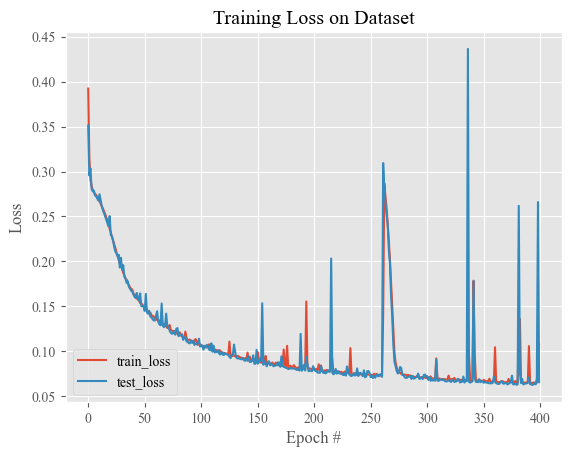

In [ ]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

plt.savefig(pathSavePlots + f'Training_Unet_12ch_GPU_01.png',
            dpi=500,
            bbox_inches = 'tight',
            pad_inches=0.25)

# serialize the model to disk
#torch.save(unet, config.MODEL_PATH)

# Save model

In [ ]:
path_save_models = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/ML_models/'
name_model = 'model_Unet_12ch_GPU_01.pth' #

# serialize the model to disk
#torch.save(unet, config.MODEL_PATH)
torch.save(unet.state_dict(), path_save_models + name_model)

In [ ]:
os.listdir('/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/ML_models')

['model_RegLog_002.pkl',
 'model_RegLog_003.pkl',
 'model_RegLog_004.pkl',
 'model_RegLog_005.pkl',
 'model_RegLog_006.pkl',
 'model_RegLog_007.pkl',
 'model_RegLog_008.pkl',
 'model_RegLog_009.pkl',
 'model_RegLog_010.pkl',
 'model_RegLog_001.pkl',
 'model_RegLog_011.pkl',
 'model_RegLog_012.pkl',
 'model_RegLog_013.pkl',
 'model_RegLog_014.pkl',
 'model_RegLog_015.pkl',
 'model_RegLog_016.pkl',
 'model_RegLog_017.pkl',
 'model_RegLog_018.pkl',
 'model_RegLog_019.pkl',
 'model_RegLog_020.pkl',
 'model_RegLog_021.pkl',
 'model_RegLog_022.pkl',
 'model_RegLog_023.pkl',
 'model_RegLog_024.pkl',
 'model_RegLog_025.pkl',
 'model_RegLog_026.pkl',
 'model_RegLog_027.pkl',
 'model_RegLog_028.pkl',
 'model_RegLog_029.pkl',
 'model_RegLog_030.pkl',
 'df_30models_LogReg.csv',
 'model_RandForest_001.pkl',
 'model_RandForest_002.pkl',
 'model_RandForest_003.pkl',
 'model_RandForest_004.pkl',
 'model_RandForest_005.pkl',
 'model_RandForest_006.pkl',
 'model_RandForest_007.pkl',
 'model_RandForest_0

# End